In [11]:
import requests
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import numpy as np
import matplotlib.pyplot as plt
from Bio import PDB
from Bio.PDB import *
import py3Dmol
import pandas as pd
from IPython.display import display, HTML
import json
import os
from Bio import SeqIO
import math
import tempfile

In [2]:
def fetch_pdb_structure(pdb_id):
    try:
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        response = requests.get(url)
        
        if response.status_code == 200:
            with open(f"{pdb_id}.pdb", "w") as f:
                f.write(response.text)
            return f"{pdb_id}.pdb"
        else:
            raise Exception(f"Failed to fetch PDB structure. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error fetching PDB structure: {e}")
        return None

In [3]:
def fetch_alphafold_prediction(uniprot_id):
    try:
        url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
        response = requests.get(url)
        
        if response.status_code == 200:
            with open(f"AF-{uniprot_id}.pdb", "w") as f:
                f.write(response.text)
            return f"AF-{uniprot_id}.pdb"
        else:
            raise Exception(f"Failed to fetch AlphaFold prediction. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error fetching AlphaFold prediction: {e}")
        return None


In [5]:
def visualize_protein(pdb_file, width=800, height=600):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open(pdb_file, 'r').read(), 'pdb')
    viewer.setStyle({'cartoon': {'color': 'spectrum'}})
    viewer.zoomTo()
    return viewer

In [7]:
def compare_structures(pdb_file1, pdb_file2):
    """
    goal of this func is to take two pdb files, overlap them and figure out how many residues are aligned using PDB Superimposer
    """
    parser = PDB.PDBParser(QUIET=True)
    
    struct1 = parser.get_structure('struct1', pdb_file1)
    struct2 = parser.get_structure('struct2', pdb_file2)
    
    ref_atoms = []
    alt_atoms = []
    
    ref_res = list(struct1.get_residues())
    alt_res = list(struct2.get_residues())
    
    min_length = min(len(ref_res), len(alt_res))
    
    for i in range(min_length):
        if 'CA' in ref_res[i] and 'CA' in alt_res[i]:
            ref_atoms.append(ref_res[i]['CA'])
            alt_atoms.append(alt_res[i]['CA'])
    
    if len(ref_atoms) == 0:
        return {
            'rmsd': None,
            'rotran': None,
            'error': 'No matching CA atoms found'
        }
    
    super_imposer = PDB.Superimposer()
    try:
        super_imposer.set_atoms(ref_atoms, alt_atoms)
        super_imposer.apply(struct2.get_atoms())
        
        return {
            'rmsd': super_imposer.rms,
            'rotran': super_imposer.rotran,
            'aligned_residues': len(ref_atoms),
            'total_residues1': len(list(struct1.get_residues())),
            'total_residues2': len(list(struct2.get_residues()))
        }
    except Exception as e:
        return {
            'rmsd': None,
            'rotran': None,
            'error': str(e)
        }

In [8]:

PDB_ID = "1AF4"  # Example PDB ID
UNIPROT_ID = "P00780"  # Example UniProt ID

pdb_file = fetch_pdb_structure(PDB_ID)
alphafold_file = fetch_alphafold_prediction(UNIPROT_ID)

if pdb_file and alphafold_file:
    print("Experimental Structure:")
    viewer1 = visualize_protein(pdb_file)
    display(viewer1)
    
    viewer2 = visualize_protein(alphafold_file)
    display(viewer2)
    
    # comparing the strucutres
    comparison_results = compare_structures(pdb_file, alphafold_file)
    print(f"\nStructure Comparison Results:")
    if 'error' in comparison_results and comparison_results['error']:
        print(f"Error in comparison: {comparison_results['error']}")
    else:
        print(f"RMSD: {comparison_results['rmsd']:.2f} Å")
        print(f"Aligned residues: {comparison_results['aligned_residues']}")
        print(f"Total residues in structure 1: {comparison_results['total_residues1']}")
        print(f"Total residues in structure 2: {comparison_results['total_residues2']}")

def check_structure(pdb_file):
    try:
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure('test', pdb_file)
        residues = list(structure.get_residues())
        return {
            'valid': True,
            'residue_count': len(residues),
            'chains': len(list(structure.get_chains()))
        }
    except Exception as e:
        return {
            'valid': False,
            'error': str(e)
        }

if pdb_file and alphafold_file:
    print("\nChecking structure files:")
    pdb_check = check_structure(pdb_file)
    af_check = check_structure(alphafold_file)
    
    print("\nPDB structure:")
    if pdb_check['valid']:
        print(f"Residues: {pdb_check['residue_count']}")
        print(f"Chains: {pdb_check['chains']}")
    else:
        print(f"Error: {pdb_check['error']}")
        
    print("\nAlphaFold structure:")
    if af_check['valid']:
        print(f"Residues: {af_check['residue_count']}")
        print(f"Chains: {af_check['chains']}")
    else:
        print(f"Error: {af_check['error']}")

Experimental Structure:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Structure Comparison Results:
RMSD: 21.68 Å
Aligned residues: 275
Total residues in structure 1: 347
Total residues in structure 2: 379

Checking structure files:

PDB structure:
Residues: 347
Chains: 1

AlphaFold structure:
Residues: 379
Chains: 1


In [12]:
class ProteinStructureAnalyzer:
    def __init__(self):
        self.alphafold_db_url = "https://alphafold.ebi.ac.uk/files"
    
    def fetch_pdb_structure(self, pdb_id):
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
        response = requests.get(url)
        if response.status_code == 200:
            with open(f"{pdb_id}.pdb", "w") as f:
                f.write(response.text)
            return f"{pdb_id}.pdb"
        return None

    def fetch_alphafold_structure(self, uniprot_id):
        versions = ['v4', 'v3', 'v2']
        for version in versions:
            url = f"{self.alphafold_db_url}/AF-{uniprot_id}-F1-model_{version}.pdb"
            response = requests.get(url)
            if response.status_code == 200:
                filename = f"AF-{uniprot_id}.pdb"
                with open(filename, "w") as f:
                    f.write(response.text)
                return filename
        return None

    def visualize_structure(self, pdb_file, title="Protein Structure"):
        with open(pdb_file) as f:
            pdb_data = f.read()
            
        viewer = py3Dmol.view(width=800, height=600)
        viewer.addModel(pdb_data, "pdb")
        viewer.setStyle({'cartoon': {'color': 'spectrum'}})
        viewer.zoomTo()
        
        print(title)
        return viewer

    def compare_structures(self, pdb_file1, pdb_file2):
        parser = PDB.PDBParser(QUIET=True)
        
        struct1 = parser.get_structure('struct1', pdb_file1)
        struct2 = parser.get_structure('struct2', pdb_file2)
        
        ref_atoms = []
        alt_atoms = []
        
        ref_res = list(struct1.get_residues())
        alt_res = list(struct2.get_residues())
        min_length = min(len(ref_res), len(alt_res))
        
        for i in range(min_length):
            if 'CA' in ref_res[i] and 'CA' in alt_res[i]:
                ref_atoms.append(ref_res[i]['CA'])
                alt_atoms.append(alt_res[i]['CA'])
        
        super_imposer = PDB.Superimposer()
        super_imposer.set_atoms(ref_atoms, alt_atoms)
        super_imposer.apply(struct2.get_atoms())
        
        return {
            'rmsd': super_imposer.rms,
            'aligned_residues': len(ref_atoms),
            'total_residues1': len(ref_res),
            'total_residues2': len(alt_res)
        }

    def plot_residue_distances(self, pdb_file1, pdb_file2):
        parser = PDB.PDBParser(QUIET=True)
        
        struct1 = parser.get_structure('struct1', pdb_file1)
        struct2 = parser.get_structure('struct2', pdb_file2)
        
        distances = []
        residue_numbers = []
        
        for (res1, res2) in zip(struct1.get_residues(), struct2.get_residues()):
            if 'CA' in res1 and 'CA' in res2:
                distance = res1['CA'] - res2['CA']
                distances.append(distance)
                residue_numbers.append(res1.get_id()[1])
        
        plt.figure(figsize=(12, 6))
        plt.plot(residue_numbers, distances)
        plt.xlabel('Residue Number')
        plt.ylabel('Distance (Å)')
        plt.title('Residue-wise Distances Between Structures')
        plt.grid(True)
        plt.show()

def main():
    analyzer = ProteinStructureAnalyzer()
    
    pdb_id = input("Enter PDB ID (e.g., 1ak4): ")
    uniprot_id = input("Enter UniProt ID (e.g., P61823): ")
    
    print("Fetching structures...")
    pdb_file = analyzer.fetch_pdb_structure(pdb_id)
    af_file = analyzer.fetch_alphafold_structure(uniprot_id)
    
    if pdb_file and af_file:
        print("\nVisualizing structures:")
        viewer1 = analyzer.visualize_structure(pdb_file, "Experimental Structure (PDB)")
        display(viewer1)
        
        viewer2 = analyzer.visualize_structure(af_file, "AlphaFold Structure")
        display(viewer2)
        
        results = analyzer.compare_structures(pdb_file, af_file)
        print("\nStructure Comparison Results:")
        print(f"RMSD: {results['rmsd']:.2f} Å")
        print(f"Aligned residues: {results['aligned_residues']}")
        print(f"Total residues in PDB: {results['total_residues1']}")
        print(f"Total residues in AlphaFold: {results['total_residues2']}")
        
        # Plot residue distances
        print("\nPlotting residue-wise distances...")
        analyzer.plot_residue_distances(pdb_file, af_file)
    else:
        print("Failed to fetch one or both structures.")

if __name__ == "__main__":
    main()

Fetching structures...
Failed to fetch one or both structures.


In [14]:
class HelixAnalyzer:
    def __init__(self):
        self.parser = PDB.PDBParser(QUIET=True)

    def find_alpha_helices(self, pdb_file):
        try:
            structure = self.parser.get_structure('protein', pdb_file)
            helices = []
            
            for model in structure:
                for chain in model:
                    residues = list(chain)
                    current_helix = None
                    
                    for i in range(len(residues)-3): 
                      
                        res_group = residues[i:i+4]
                        
                     
                        if not all('CA' in res for res in res_group):
                            continue
                        
                       
                        ca_atoms = [res['CA'] for res in res_group]
                        
                        
                        if self.is_helical_segment(ca_atoms):
                            if current_helix is None:
                                current_helix = {
                                    'chain': chain.id,
                                    'start': residues[i].id[1],
                                    'residues': []
                                }
                            current_helix['residues'].append(residues[i].id[1])
                        else:
                            if current_helix and len(current_helix['residues']) >= 4:
                                current_helix['end'] = current_helix['residues'][-1]
                                helices.append(current_helix)
                            current_helix = None
                    
                   
                    if current_helix and len(current_helix['residues']) >= 4:
                        current_helix['end'] = current_helix['residues'][-1]
                        helices.append(current_helix)
            
            return helices
            
        except Exception as e:
            print(f"Error in helix analysis: {e}")
            return []

    def is_helical_segment(self, ca_atoms):
        """
       this is confusing but Im trying to figure out if the atoms selected for a helix pattern
        """
        try:
            
            for i in range(len(ca_atoms)-1):
                distance = ca_atoms[i] - ca_atoms[i+1]
                if not (3.0 <= distance <= 4.5):  
                    return False
            
            distance_i_to_i3 = ca_atoms[0] - ca_atoms[3]
            if not (4.5 <= distance_i_to_i3 <= 6.5):  # can change this distance
                return False
                
            return True
            
        except Exception as e:
            print(f"Error checking helical segment: {e}")
            return False

def main():
    analyzer = HelixAnalyzer()
    
    pdb_id = input("Enter PDB ID (e.g., 1AKE): ").upper()
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    
    try:
        print(f"\nDownloading {pdb_id}...")
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Failed to fetch PDB file for {pdb_id}")
            return

        with tempfile.NamedTemporaryFile(mode='w', suffix='.pdb', delete=False) as temp_file:
            temp_file.write(response.text)
            temp_filename = temp_file.name
        
        print(f"Analyzing {pdb_id}...")
        helices = analyzer.find_alpha_helices(temp_filename)
        
        if helices:
            print(f"\nFound {len(helices)} alpha helices:")
            for i, helix in enumerate(helices, 1):
                print(f"Helix {i}: Chain {helix['chain']}, residues {helix['start']}-{helix['end']} "
                      f"(length: {len(helix['residues'])} residues)")
                
            total_residues = sum(len(h['residues']) for h in helices)
            print(f"\nTotal residues in helices: {total_residues}")
        else:
            print("\nNo alpha helices found.")
            
            structure = analyzer.parser.get_structure('protein', temp_filename)
            total_residues = sum(1 for _ in structure.get_residues())
            print(f"Total residues in structure: {total_residues}")
            
            ca_count = sum(1 for res in structure.get_residues() if 'CA' in res)
            print(f"Residues with CA atoms: {ca_count}")
            
    except Exception as e:
        print(f"Error: {e}")
    finally:
        if 'temp_filename' in locals():
            os.unlink(temp_filename)

if __name__ == "__main__":
    main()


Analyzing 1AKE...

Found 18 alpha helices:
Helix 1: Chain A, residues 12-22 (length: 11 residues)
Helix 2: Chain A, residues 30-39 (length: 10 residues)
Helix 3: Chain A, residues 49-53 (length: 5 residues)
Helix 4: Chain A, residues 60-71 (length: 12 residues)
Helix 5: Chain A, residues 89-97 (length: 9 residues)
Helix 6: Chain A, residues 115-120 (length: 6 residues)
Helix 7: Chain A, residues 160-172 (length: 13 residues)
Helix 8: Chain A, residues 174-186 (length: 13 residues)
Helix 9: Chain A, residues 201-211 (length: 11 residues)
Helix 10: Chain B, residues 12-22 (length: 11 residues)
Helix 11: Chain B, residues 30-39 (length: 10 residues)
Helix 12: Chain B, residues 49-53 (length: 5 residues)
Helix 13: Chain B, residues 60-71 (length: 12 residues)
Helix 14: Chain B, residues 89-97 (length: 9 residues)
Helix 15: Chain B, residues 115-120 (length: 6 residues)
Helix 16: Chain B, residues 160-173 (length: 14 residues)
Helix 17: Chain B, residues 175-186 (length: 12 residues)
Helix

Starting helix comparison analysis...
Starting analysis of 20 protein pairs...
--------------------------------------------------

Analyzing pair 1/20: 1AKE - P69441
  Fetching official PDB helix count...
    Found 18 helices in PDB structure
  Analyzing AlphaFold structure...
  Results:
    PDB helices (official): 18
    AF helices (predicted): 10
    Difference: -8

Analyzing pair 2/20: 1TIM - P60174
  Fetching official PDB helix count...
    Found 24 helices in PDB structure
  Analyzing AlphaFold structure...
  Results:
    PDB helices (official): 24
    AF helices (predicted): 12
    Difference: -12

Analyzing pair 3/20: 3PGK - P00560
  Fetching official PDB helix count...
    Found 14 helices in PDB structure
  Analyzing AlphaFold structure...
  Results:
    PDB helices (official): 14
    AF helices (predicted): 15
    Difference: 1

Analyzing pair 4/20: 1HEL - P00698
  Fetching official PDB helix count...
    Found 7 helices in PDB structure
  Analyzing AlphaFold structure...
  R

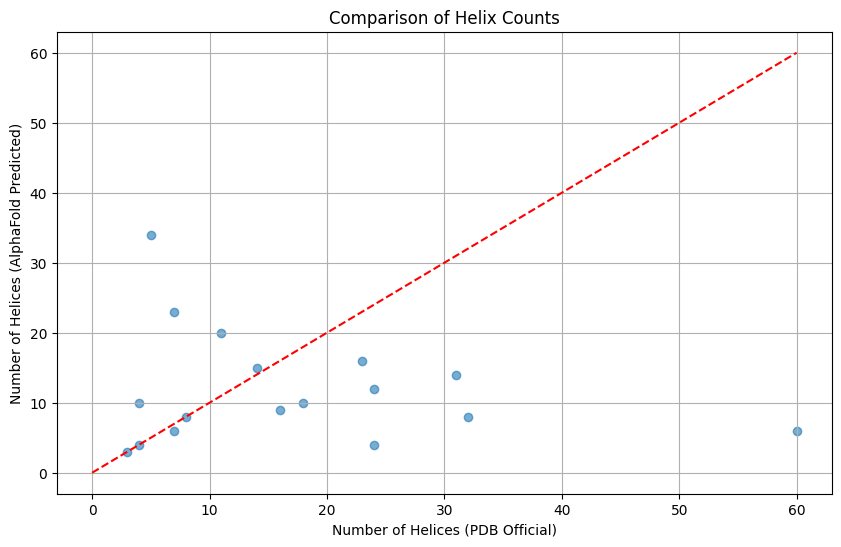

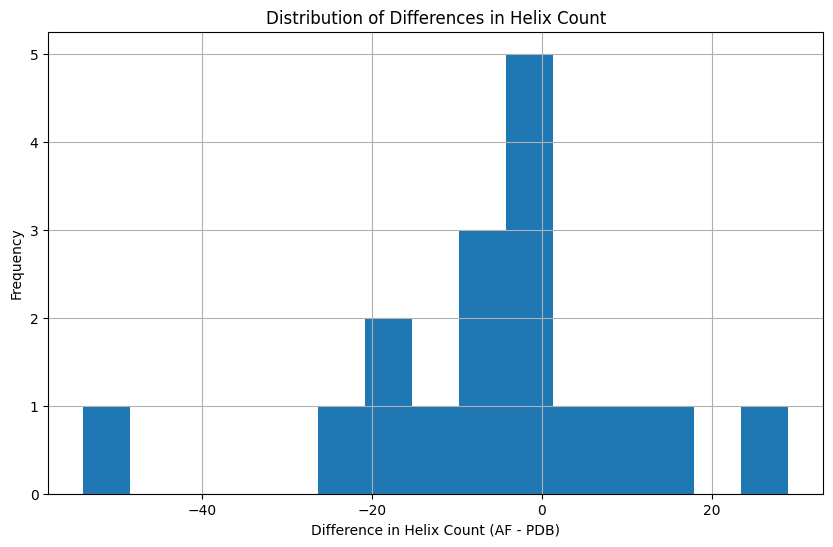

Analysis complete!


In [16]:
class HelixComparator:
    def __init__(self):
        self.parser = PDB.PDBParser(QUIET=True)
        self.PROTEIN_PAIRS = [
            ("1AKE", "P69441"), ("1TIM", "P60174"), ("3PGK", "P00560"),
            ("1HEL", "P00698"), ("2LZM", "P00720"), ("1MBO", "P02185"),
            ("1HHB", "P68871"), ("4HHB", "P69905"), ("1UBQ", "P62988"),
            ("1RX2", "P61823"), ("1NEQ", "P02768"), ("1GKA", "P02787"),
            ("1MTP", "P02789"), ("1AO6", "P02647"), ("1CLL", "P62158"),
            ("1ATN", "P68133"), ("2KHO", "P68371"), ("1YRF", "P04259"),
            ("1COL", "P02452"), ("1EMA", "P02671")  # Reduced to 20 for testing
        ]

    def get_pdb_helix_count(self, pdb_id):
        try:
            # Download PDB file
            url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
            response = requests.get(url)
            
            if response.status_code == 200:
                # Save temporarily
                with tempfile.NamedTemporaryFile(mode='w', suffix='.pdb', delete=False) as temp_file:
                    temp_file.write(response.text)
                    temp_filename = temp_file.name
                
                try:
                    # Parse structure
                    structure = self.parser.get_structure('temp', temp_filename)
                    helix_count = 0
                    current_helix = False
                    
                    # Parse HELIX records from PDB header
                    for line in response.text.split('\n'):
                        if line.startswith('HELIX'):
                            helix_count += 1
                    
                    print(f"    Found {helix_count} helices in PDB structure")
                    return helix_count
                    
                finally:
                    os.unlink(temp_filename)
                    
            return None
        except Exception as e:
            print(f"Error processing PDB structure: {e}")
            return None

    def find_helices_alphafold(self, structure_string):
        if not structure_string:
            return []

        with tempfile.NamedTemporaryFile(mode='w', suffix='.pdb', delete=False) as temp_file:
            temp_file.write(structure_string)
            temp_filename = temp_file.name

        try:
            structure = self.parser.get_structure('temp', temp_filename)
            helices = []
            
            for model in structure:
                for chain in model:
                    residues = list(chain)
                    current_helix = None
                    
                    for i in range(len(residues)-3):
                        res_group = residues[i:i+4]
                        
                        if not all('CA' in res for res in res_group):
                            continue
                        
                        ca_atoms = [res['CA'] for res in res_group]
                        
                        if self.is_helical_segment(ca_atoms):
                            if current_helix is None:
                                current_helix = {
                                    'chain': chain.id,
                                    'start': residues[i].id[1],
                                    'residues': []
                                }
                            current_helix['residues'].append(residues[i].id[1])
                        else:
                            if current_helix and len(current_helix['residues']) >= 4:
                                current_helix['end'] = current_helix['residues'][-1]
                                helices.append(current_helix)
                            current_helix = None
                    
                    if current_helix and len(current_helix['residues']) >= 4:
                        current_helix['end'] = current_helix['residues'][-1]
                        helices.append(current_helix)
            
            return helices
        
        finally:
            os.unlink(temp_filename)

    def is_helical_segment(self, ca_atoms):
        try:
            for i in range(len(ca_atoms)-1):
                distance = ca_atoms[i] - ca_atoms[i+1]
                if not (3.0 <= distance <= 4.5):
                    return False
            
            distance_i_to_i3 = ca_atoms[0] - ca_atoms[3]
            return 4.5 <= distance_i_to_i3 <= 6.5
            
        except:
            return False

    def fetch_alphafold_structure(self, uniprot_id):
        url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                return response.text
            return None
        except:
            return None

    def analyze_all_proteins(self):
        results = []
        total = len(self.PROTEIN_PAIRS)
        
        print(f"Starting analysis of {total} protein pairs...")
        print("-" * 50)
        
        for i, (pdb_id, uniprot_id) in enumerate(self.PROTEIN_PAIRS, 1):
            print(f"\nAnalyzing pair {i}/{total}: {pdb_id} - {uniprot_id}")
            
            print(f"  Fetching official PDB helix count...")
            pdb_helices = self.get_pdb_helix_count(pdb_id)
            
            print(f"  Analyzing AlphaFold structure...")
            af_struct = self.fetch_alphafold_structure(uniprot_id)
            
            if pdb_helices is not None and af_struct:
                af_helices = self.find_helices_alphafold(af_struct)
                
                result = {
                    'PDB_ID': pdb_id,
                    'UniProt_ID': uniprot_id,
                    'PDB_Helices': pdb_helices,
                    'AF_Helices': len(af_helices),
                    'Difference': len(af_helices) - pdb_helices
                }
                
                print(f"  Results:")
                print(f"    PDB helices (official): {result['PDB_Helices']}")
                print(f"    AF helices (predicted): {result['AF_Helices']}")
                print(f"    Difference: {result['Difference']}")
                
                results.append(result)
            else:
                print(f"  Failed to fetch data")
        
        return pd.DataFrame(results)

    def plot_results(self, df):
        plt.figure(figsize=(10, 6))
        plt.scatter(df['PDB_Helices'], df['AF_Helices'], alpha=0.6)
        max_val = max(df['PDB_Helices'].max(), df['AF_Helices'].max())
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xlabel('Number of Helices (PDB Official)')
        plt.ylabel('Number of Helices (AlphaFold Predicted)')
        plt.title('Comparison of Helix Counts')
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.hist(df['Difference'], bins=15)
        plt.xlabel('Difference in Helix Count (AF - PDB)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Differences in Helix Count')
        plt.grid(True)
        plt.show()

def main():
    print("Starting helix comparison analysis...")
    comparator = HelixComparator()
    
    results_df = comparator.analyze_all_proteins()
    
    print("\nSummary Statistics:")
    print("-" * 50)
    print(f"Total proteins analyzed: {len(results_df)}")
    print(f"Average PDB helices: {results_df['PDB_Helices'].mean():.2f}")
    print(f"Average AF helices: {results_df['AF_Helices'].mean():.2f}")
    print(f"Average difference: {results_df['Difference'].mean():.2f}")
    print(f"Median difference: {results_df['Difference'].median():.2f}")
    print(f"\nCorrelation coefficient: {results_df['PDB_Helices'].corr(results_df['AF_Helices']):.3f}")
    
    results_df.to_csv('helix_comparison_results.csv', index=False)
    print("\nResults saved to 'helix_comparison_results.csv'")
    
    print("\nGenerating plots...")
    comparator.plot_results(results_df)
    print("Analysis complete!")

if __name__ == "__main__":
    main()